# 2. Country level spread dynamics

At the country level, the dynamics of the disease spread can be described using the same means as the dynamics of the incidence within the city. Individual cities will act as infected persons. In this situation, we have an obvious observable parameter responsible for the individual differences between cities — the size of the city (city population size). 

The country level disease spread is due to intercity visits. Let's assume that the number of people visiting a city is directly proportional to its size. This means that the relative (to the population size of the city) human influx does not depend on the size. Another assumption is that the social capacity to infect (roughly speaking activity) brought in by one host does not depend on the size of the city (although there are more opportunities for social activity in a larger city). Under these assumptions for any of the cities, the part of population infected by the visitors turns out to depend only on the proportion of the infected in those cities the visitors arriving from. Thus, the intercity disease spread becomes independent of cities sizes, and we get ordinary [SEIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model).

The model consists of four compartments $S$usceptible, $E$xposed,$I$nfectious, and $R$ecovered. Being infected by initial group of visitors a city moves from Susceptible to Recovered according to its individual internal  dynamics depended on the city population social heterogeneity controlled by $v_s$ and inside city initial reproduction number $r_0$(see city level dinamics) and so on.   Assuming the set of cities to be fixed without the birth of new ones and the death of old ones, we obtain a system of SEIR equations:

$$
\begin{align}
\frac{dS}{dt} & = - \beta I S \\[3pt]
\frac{dE}{dt} & = \beta I S - \frac{E}{\tau_E} \\[3pt]
\frac{dI}{dt} & = \frac{E}{\tau_E} - \frac{I}{\tau_I} \\[3pt]
R &=1-S-E-I
\end{align}
$$
We suggest the city get infected and becomes Exposed at the moment when the portion of its infected population becomes equal to some value $i_0$. Up to the mentioned moment we consider the dynamics of the city infected population as defined by external infection influx only, starting from the moment we consider the dynamics of the city infected population as defined by internal dynamics only.  We also suggest  all the parameters defining the internal dynamics are the same for all the cities. In this case the internal dynamics of each infected city is the same. Calculating the dynamisc for one of the cities we use some thresholds to divide the evolution of infection into Exposed,Infectious, and Recovered parts. That way we not only simplify the model and makes it more tractable, but infer the value of the $\tau_E$ and $\tau_I$ for the SEIR equations, and also average infected population portion $\mathcal{I}$ for the infected cities.

Let each of the cities have the same the visitors influx $w\in [0,1]$ (relative to its size) in a unit of time. The out flux value is the same but formed by arbitrary persons not necessary those in influx.  That means in a time unit $w\cdot I \cdot \mathcal{I}$ infected visitors visits a city, and as long as the city stays uninfected there is no out flux of infected persons. So for the city to get infected and become Exposed it takes 
$$
\frac{i_0}{w\cdot \mathcal{I} \cdot I }
$$
units of time, and probability to get infected at a unit of time is the inverse value 
$$
\frac{w\cdot \mathcal{I}\cdot I }{i_0}
$$
Thus, change in amount of Susceptible cities in $dt$ time is
$$
dS=-\frac{w\cdot \mathcal{I}\cdot I }{i_0}S dt
$$
or
$$
\frac{dS}{dt}=-\frac{w \mathcal{I}}{i_0}I S
$$
That means the $\beta$ coefficient in the SEIR equasions is given by:
$$
\beta=\frac{w \mathcal{I}}{i_0}
$$

Assuming everage citizen have one visits a year and 25 time units in the year, we choose $w$ equal to 0.04.

First, we calculate the pattern of a city infection dynamics based on HCS SIR model 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scst
import scipy.special as scsp
import scipy.integrate as scint
import scipy.optimize as scop
from scipy.integrate import odeint
import matplotlib.ticker as ticker
from dataclasses import dataclass
plt.rc('legend',fontsize=12, handlelength=2) # using a size in points

plt.style.use('seaborn-darkgrid')

modeling_period=20.0
t_step=0.01
m_t=np.arange(0.0, modeling_period+t_step, t_step,dtype=np.float64)
n_steps=len(m_t)-1
def M(mu,v):return np.exp(mu+0.5*v)

In [2]:
def HCS_SIR(r0_0,I0,τ,vs0,vb0):
    '''
    Heterogeneous in Catching and Spreading
    SIR model
    '''
    def a_s(mus,C,vs):
        Cpvs=C+vs
        return M(mus,vs)*(1.0+Cpvs*(1.0+0.5*Cpvs))
    M0=M(0.0,vs0+vb0)
    a_s0=r0_0*a_s(0.0,0.0,vs0)/(r0_0-1.0+1.0/τ)
    α=r0_0/M0/a_s0
    
    def ODE(y,t):
        S,I,A,mus,mub,C,vs,vb=y
        Cpvs=C+vs
        Cpvb=C+vb 
        minus_αMA=-α*M(mus+mub,Cpvs+Cpvb)*A

        dS = minus_αMA*S
        dI = -dS - I
        dA= -a_s(mus,C,vs)*dS-A/τ
        dmus = minus_αMA*Cpvs
        dmub = minus_αMA*Cpvb
        dC = dmus*Cpvb
        dvs = dmus*Cpvs
        dvb = dmub*Cpvb
        return [dS, dI,dA, dmus,dmub,dC,dvs,dvb]
    
    A0=a_s0*I0
    y0=[1.0-I0,I0,A0,0.0,0.0,0.0,vs0,vb0]
    
    sol = odeint(ODE,y0, m_t).T
    S,I,A,mus,mub,C,vs,vb=sol
    dS=-ODE(sol,m_t)[0]
    R=1.0-S-I
    return S,I,R,dS

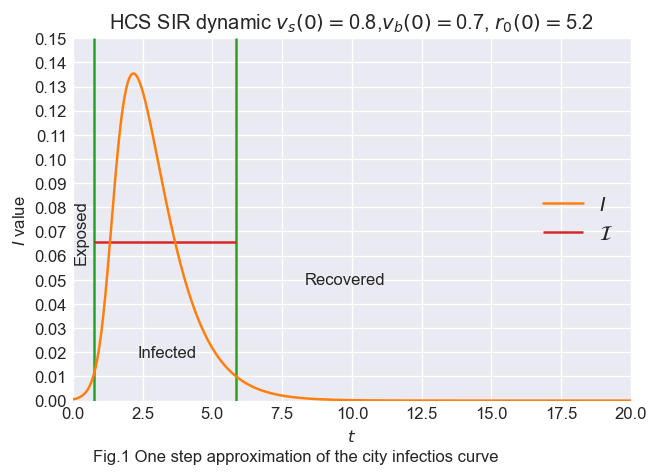

In [3]:
τ=0.4
vs0=0.8
vb0=0.7
r0_0=5.2
i0=0.0005
S,I,_,_= HCS_SIR(r0_0,i0,τ,vs0,vb0)

infected_threshold=0.01
infected_mask=I>infected_threshold
τ_E=t_step*np.sum(np.cumsum(infected_mask)==0)
infected=I[infected_mask]
τ_I=t_step*len(infected)
I_avr=np.mean(infected)
S_HCS=S# give distinct names to a variables
I_HCS=I

fig, ax = plt.subplots(dpi=120)

plt.plot(m_t, I,color='C1', label=f'$I$')
plt.vlines(x = [τ_E,τ_E+τ_I], ymin = 0, ymax = 0.15, 
           colors = 'C2')
plt.hlines(y = I_avr, xmin = τ_E, xmax = τ_E+τ_I, 
           colors = 'C3', label='$\mathcal{I}$')
plt.text(0.01, 0.07, "Exposed", rotation=90, verticalalignment='center')
plt.text(8.3, 0.05, "Recovered",  verticalalignment='center')
plt.text(2.3, 0.02, "Infected",  verticalalignment='center')
ax.set_ylim([0.0,.15])
ax.set_xlim([0.0,20])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.set_ylabel(f'$I$ value')
plt.legend(loc='center right')
plt.xlabel(f'$t$')
ax.text(8,-.025, 'Fig.1 One step approximation of the city infectios curve', ha='center')
plt.title(f'HCS SIR dynamic $v_s(0)=${vs0},$v_b(0)=${vb0}, $r_0(0)=${r0_0}')

plt.show()
w=0.04
β=w*I_avr/i0
#print(f'β={β}')

Now we are ready for implememting country level SEIR model (CL SEIR).

In [4]:
def CL_SEIR(I0,β,τ_E,τ_I):
    '''
    Counry level
    SEIR model
    '''
    def ODE(y,t):
        S,E,I=y
        dS = -β*I*S
        dE = -dS-E/τ_E
        dI = E/τ_E - I/τ_I
        return [dS, dE, dI]
    
    y0=[1.0-I0,0.0,I0]
    
    sol = odeint(ODE,y0, m_t).T
    S,E,I=sol
    dS=-ODE(sol,m_t)[0]
    R=1.0-S-E-I
    return S,E,I,R,dS

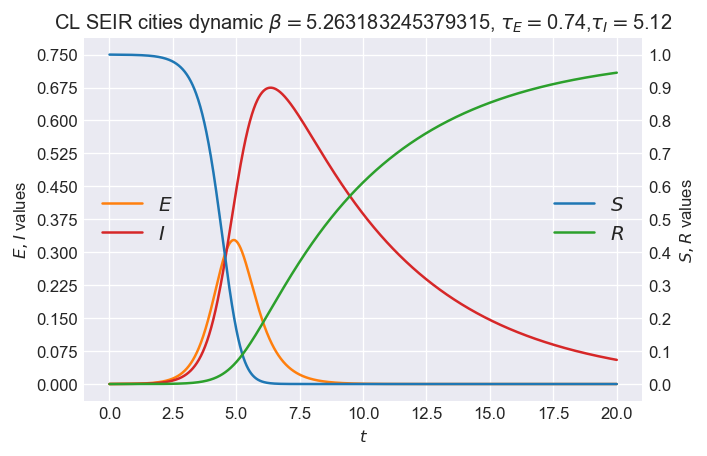

In [5]:
I0=0.0001
S,E,I,R,dS= CL_SEIR(I0,β,τ_E,τ_I)
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, E,color='C1', label=f'$E$')
plt.plot(m_t, I,color='C3', label=f'$I$')
#plt.plot(m_t, dS, color='C2', label=f'$|dS/dt|$') 
ax.set_ylim([-0.05*0.75,1.05*0.75])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.075))
ax.set_ylabel(f'$E,I$ values')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, S, color='C0', label=f'$S$')
plt.plot(m_t, R,color='C2', label=f'$R$')
ax2.set_ylim([-0.05,1.05])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.set_ylabel(f'$S,R$ values')
ax2.grid(False)

plt.legend(loc='center right')
plt.title(f'CL SEIR cities dynamic $β=${β}, $τ_E=${τ_E},$τ_I=${τ_I}')
plt.show() 

The values S,E,I,R, we have got, reflects the cities dynamics inside the country, not the country population dinamics. To get the country population dinamics we need to combine the cities dynamics and inside city dynamics via convolution. And finally  

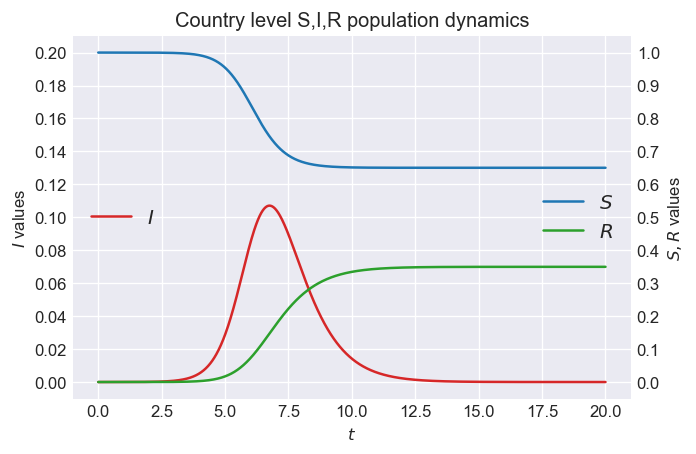

In [6]:
S_pop=1.0-np.convolve(dS,1.0-S_HCS, mode='full')[:n_steps+1]*t_step
I_pop=np.convolve(dS,I_HCS, mode='full')[:n_steps+1]*t_step
R_pop=1.0-S_pop-I_pop
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, I_pop,color='C3', label=f'$I$')
ax.set_ylim([-0.05*0.2,1.05*0.2])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.set_ylabel(f'$I$ values')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, S_pop, color='C0', label=f'$S$')
plt.plot(m_t, R_pop,color='C2', label=f'$R$')
ax2.set_ylim([-0.05,1.05])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.set_ylabel(f'$S,R$ values')
ax2.grid(False)

plt.legend(loc='center right')
plt.title(f'Country level S,I,R population dynamics')
plt.show() 

Above we actually used the city level infection dynamics being approximated by step functition to model the country dynamics. The step function was very simple. We can use more complex multi-step functions to approximate the city level infection dynamics. To  this end let's divide the timeline on $k$ jump points $t_1,...,t_k$ and assign values $\mathcal{I}_1,\mathcal{I}_2,...,\mathcal{I}_k,0$ to the intervals $[0,t_1),[t_1,t_2),...,[t_k,\infty)$ respectively getting multi-step function $\mathcal{I}(t)$. We want $\mathcal{I}(t)$ to be a good substitute for $I_{HCS}(t)$ - actual city level infection dynamics. We are choosing $\mathcal{I}(t)$ to get mimimum of the square of $L^2$ distance on the interval $[0,t_k]$:
$$ \lVert I_{HCS}-\mathcal{I}\rVert_{0,t_k}=\int_{0}^{t_k}(I_{HCS}(t)-\mathcal{I}(t))^2 dt$$

Jump points $t_1$ and $t_k$ are getting simply by use some small cutoff value $\epsilon_0$ to make $\mathcal{I}(t)$ zero where $I_{HCS}(t)$ is below the cutoff. Jump points $t_2,...,t_{k-1}$ are defined using the procedure DECIDE taken from the article https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.170.6471&rep=rep1&type=pdf . We combine the procedure DECIDE with $L^2$ square distance and 32 iterations of binary search to get  $t_2,...,t_{k-1}$ (it is not exactly minimal solution, but good enough, and we want to keep technical part simple).


In [7]:
def get_partition(y,k,eps0):
    n=len(y)
    for f0 in range(n):
        if y[f0]>eps0:
            break
    for fn in range(n-1,-1,-1):
        if y[fn]>eps0:
            break
    n,k=fn,k-1
    def DECIDE(eps):
        f=f0
        res=[0,f0]
        for j in range(k):
            Sum=y[f]
            Sum2=Sum*Sum
            N=1
            for i in range(f+1,n):
                Sum+=y[i]
                Sum2+=y[i]*y[i]
                N += 1
                if Sum2-Sum*Sum/N>eps:
                    f=i
                    break
            else:
                res.append(n+1)
                return res
            res.append(f)
        return False
    lo=0.0
    hi=np.var(y)*len(y)
    found=[]
    for i in range(32):
        guess=0.5*(lo+hi)
        p=DECIDE(guess)
        if p:
            found=p
            hi=guess
        else:
            lo=guess
    return np.array(found) 


Resulting step function looks following way (values $\mathcal{I}_1,\mathcal{I}_2,...,\mathcal{I}_k$ are just means of appropriate intervals) :

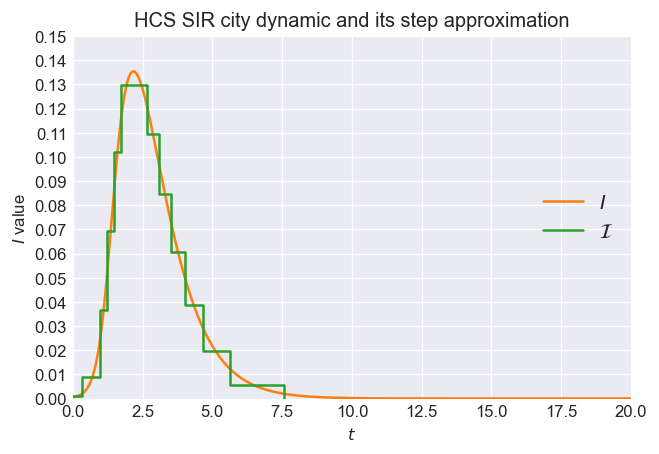

In [8]:
k=12
p=get_partition(I_HCS,k,I_HCS[0]*4)
I_step=np.array([np.mean(I_HCS[p[i]:p[i+1]]) for i in range(k)]+[0.0])
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, I_HCS,color='C1', label=f'$I$')
plt.step(t_step*p,I_step,where='post',color='C2',label='$\mathcal{I}$')
ax.set_ylim([0.0,.15])
ax.set_xlim([0.0,modeling_period])
#ax.set_xlim([0.0,0.5])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.set_ylabel(f'$I$ value')
plt.legend(loc='center right')
plt.xlabel(f'$t$')
plt.title(f'HCS SIR city dynamic and its step approximation')

plt.show()

Equations for the country level SIR model with step approximation of infectious curve (CL STEP SIR) are:
$$
\begin{align}
\frac{dS}{dt} & = -\frac{w}{i_0} S \sum_{i=1}^{k} \mathcal{I}_iI_i \\[3pt]
\frac{dI_1}{dt} & = - \frac{dS}{dt} - \frac{I_1}{\tau_1} \\[3pt]
\frac{dI_2}{dt} & = \frac{I_1}{\tau_1} - \frac{I_2}{\tau_2} \\[3pt]
 & ... \\[3pt]
R &=1-S-E-\sum_{i=1}^{k}I_i
\end{align}
$$
where $\tau_i=t_{i}-t_{i-1}$ and $t_0=0$, 

$S,I,R$ - the portion of **the cities** in appropriate (multi) compartments.



In [9]:
def CL_STEP_SIR(I0,β,k,S_HCS_SIR,I_HCS_SIR):
    '''
    Counry level
    model
    '''
    p=get_partition(I_HCS_SIR,k,I_HCS_SIR[0]*4.0)
    k=len(p)-1
    tau=t_step*(p[1:]-p[:-1])
    I_step=np.array([np.mean(I_HCS_SIR[p[i]:p[i+1]]) for i in range(k)])
    def ODE(y,t):
        S,I=y[0],y[1:]
        dS = -β*S*np.dot(I,I_step)
        outflow=I/tau
        inflow=np.roll(outflow,1)
        inflow[0]=-dS
        dI= inflow - outflow
        return np.concatenate(([dS],  dI))
    y0=np.zeros(k+1,dtype=np.float64)
    y0[0],y0[1],y0[2],y0[3]=1.0-I0,0.125*I0,0.75*I0,0.125*I0
    sol = odeint(ODE,y0, m_t).T
    
    S,I=sol[0],sol[1:].T
    I_pop=np.dot(I,I_step)
    dS=β*S*I_pop
    S_step=np.array([np.mean(S_HCS_SIR[p[i]:p[i+1]]) for i in range(k)])
    S_pop=S+np.dot(I,S_step)
    I=np.sum(I,axis=1)
    R=1.0-S-I
    S_pop+=S_HCS_SIR[-1]*R
    return S,I,R,dS,S_pop,I_pop


The procedure above calculates not only $S,I,R$ values for the cities but also $S_{pop}$ and $I_{pop}$ - appropriate country population values. On the other hand we can get $S_{pop}$ and $I_{pop}$ via convolution as previously. The difference between values obtained by different methods reflects the quality of step approximation and should vanish as number of steps $k$ increases. 

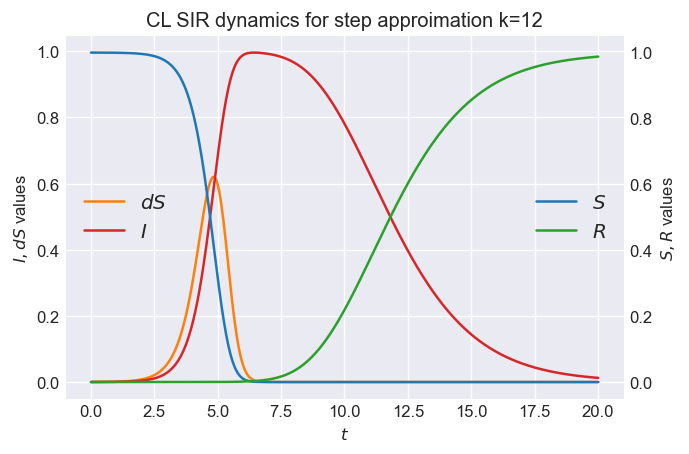

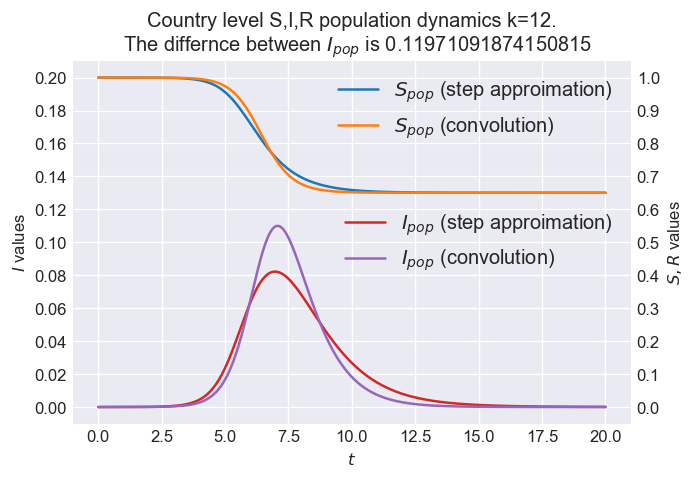

In [10]:
I0=0.0001
k=12
S,I,R,dS,S_pop1,I_pop1= CL_STEP_SIR(I0,w/i0,k,S_HCS,I_HCS)
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, dS,color='C1', label=f'$dS$')
plt.plot(m_t, I,color='C3', label=f'$I$')
ax.set_ylabel(f'$I,dS$ values')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, S, color='C0', label=f'$S$')
plt.plot(m_t, R,color='C2', label=f'$R$')
ax2.set_ylabel(f'$S,R$ values')
ax2.grid(False)

plt.legend(loc='center right')
plt.title(f'CL SIR dynamics for step approimation k={k}')
plt.show() 

S_pop2=1.0-np.convolve(dS,1.0-S_HCS, mode='full')[:n_steps+1]*t_step
I_pop2=np.convolve(dS,I_HCS, mode='full')[:n_steps+1]*t_step

fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, I_pop1,color='C3', label='$I_{pop}$ (step approimation)')
plt.plot(m_t, I_pop2,color='C4', label='$I_{pop}$ (convolution)')
ax.set_ylim([-0.05*0.2,1.05*0.2])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.set_ylabel(f'$I$ values')
plt.legend(loc='center right')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, S_pop1, color='C0', label='$S_{pop}$ (step approimation)')
plt.plot(m_t, S_pop2, color='C1', label='$S_{pop}$ (convolution)')
ax2.set_ylim([-0.05,1.05])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.set_ylabel(f'$S,R$ values')
ax2.grid(False)

plt.legend(loc='upper right')
ip='I_{pop}'
plt.title(f'Country level S,I,R population dynamics k={k}.\n  The differnce between ${ip}$ is {np.sum((I_pop1-I_pop2)**2)}')
plt.show() 



So, by increasing $k$ we get more and more "continious" solution. We can get it other way around by solving the equation:

$$\frac{dS(t)}{dt}  = -\frac{w}{i_0} S(t) \int_{0}^{t}\frac{dS(t-\tau)}{dt} I_{HCS}(\tau)d\tau$$

Here the sum in right side becomes the integral. Then by using convolution as priviously we can get $S_{pop},I_{pop},R_{pop}$. Although this way the differential equation contains only one variable the equation is not ODE, but D(delayed)DE. Even simple DDE much harder to solve and there are no standard tools for that in scipy. Besides right side contains computationally intensive convolution.

We started from assumption that the number of people visiting a city is directly proportional to its size. Also, we have assumed that the social capacity to infect brought in by one host does not depend on the size of the city as all parameters defining spreading inside the city.

Yet, more realistic assumption is that number of people visiting a city is more than just proportional to its population size $z$ (in some countries, for example, only capitals have international airports so everyone travelling abroad have to visit the capitals) and, say, proportional to $z^{1+\theta}$. That makes large cities more vulnerable to infection, and we will get like SEIR model with probability for the city to get infected proportional to $z^\theta$. The parameters defining internal city spread dynamics $r_0$ and $\exp(v_s(0))-1$ 
>$v_s(0)$ is the variance of logarithms, see "1.2. Heterogeneity in spreading the disease" and explanations below 

also influenced by the city size and, say, proportional to $z^{\theta_r}$ and $z^{\theta_v}$ respecively.

Many sources suggest $\theta$ value around 1/6.  We use following paper
__[Schläpfer M, Bettencourt L, Grauwin S, Raschke M, Claxton R, Smoreda Z, West G B and Ratti C. 
The scaling of human interactions with city size (2013)](http://arxiv.org/abs/1210.5215)__  to pick up the value. The paper estimate $\theta$ belonging to the range [0.08,0.15]. We choose 0.1 as a value for $\theta$, $\theta_r$ and a half of that 0.05 as a value for $\theta_v$.
>Some additional considerations can be found here _A. J. Stier, M. G. Berman, and L. Bettencourt, Covid-19 attack rate increases with city size, arXiv preprint arXiv:2003.10376, (2020)_


It is known that the distribution of cities by population roughly corresponds to Zipf's law with exponent around 1. As continuous functions more preferable for the differential equations we will model the cities size distribution as a continuous random variable $Z$. To this means we use bounded __[Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution)__  with shape parameter equal to one, support $[l,h]$, and PDF
$$f(z)=\frac{lh}{h-l}z^{-2}$$
where l and h is the population size limits (as a part of the whole country population) for smallest and largest cities , for example 1.0e-6 and 0.05. If the total number of cities is $C$, then in the interval $[z,z+dz]$ it will be 
$$C f(z) dz$$ 
cities with population
$$C z f(z) dz$$
For the entire interval $[l, h]$, we must get the entire population, which we consider equal to 1. So, having $l$ and $h$ chosen, the total number of cities $C$ must satisfy
$$C\int_l^hzf(z)dz=N\frac{lh}{h-l}(\ln(h)-\ln(l))=1$$
or
$$C=\frac{h-l}{lh(\ln(h)-\ln(l))}$$

Let $s(z,t)$ is the portion (at moment t) of susceptible cities of size $z$. At the beginning it is (almost) equal to one for all $z$ and moves down to zero in time as more and more cities get infected. The same way we can define $e(z,t)$ and $i(z,t)$ - the proportions of exposed and infectious cities respectively. We also needs value describing a portion of infectios population for infectious cities of given size - $\mathcal{I}(z)$ so we consider one step approximation of the city infectios curve as in Fig.1. 

Than we can write down equations:
$$
\begin{align}
\frac{\mathrm{d}s(z,t)}{\mathrm{d}t} & = -\frac{w}{i_0\mathbb{E}[z^\theta]} z^\theta s(z,t) I_p(t) \\[3pt]
\frac{\mathrm{d}e(z,t)}{\mathrm{d}t} & = - \frac{\mathrm{d}s(z,t)}{\mathrm{d}t} - \frac{e(z,t)}{\tau_e(z)} \\[3pt]
\frac{\mathrm{d}i(z,t)}{\mathrm{d}t} & = \frac{e(z,t)}{\tau_e(z)} - \frac{i(z,t)}{\tau_i(z)} \\[3pt]
\end{align}
$$

Here $I_p(t)=C\,\mathbb{E}[z\, i(z,t)\mathcal{I}(z)]$ - the portion of infectious population as the part of the whole country population and $\mathbb{E}[g(z,...)]$ is expectation
$$\mathbb{E}[g(z,...)]=\int_{l}^{h} g(z,...) f(z)\mathrm{d}z=\frac{hl}{h-l}\int_{l}^{h} g(z,...) z^{-2}\mathrm{d}z$$

Indeed, there are
$$dI=C\, i(z,t) f(z) dz$$ 
infectious cities in the interval $[z,z+dz]$ having population
$$dp=z\, dI=C\, z\, i(z,t) f(z) dz$$
and part $\mathcal{I}(z)$ of $dp$ is infectious. So
$$dI_p=\mathcal{I}(z) dp=C\, z\, i(z,t) \mathcal{I}(z) f(z) dz$$ 
integrating over $[l,h]$ gives
$$I_p=\int_{l}^{h}dI_p=C \int_{l}^{h}z\, i(z,t) \mathcal{I}(z) f(z) dz=C\,\mathbb{E}[z\, i(z,t)\mathcal{I}(z)]$$ 


For $s(z,t)$ we use the same trick as previosely. Lets represent $s(z,t)$ following way
$$s(z,t)=\exp(-z^\theta u(t))$$
Denoting $w/(i_0\mathbb{E}[z^\theta])$ as $\beta^*$ we get first equation without $z$

$$\frac{\mathrm{d}u(t)}{\mathrm{d}t} = \beta^* I_p(t)$$
Than second equation becomes:
$$\frac{\mathrm{d}e(z,t)}{\mathrm{d}t}  = \beta^*z^\theta\exp(-z^\theta u(t))I_p(t) - \frac{e(z,t)}{\tau_e(z)}$$
The third equation stays unchanged.

To solve the equations we need to find $\mathbb{E}[z\, i(z,t)\mathcal{I}(z)]$ at each right side estimation by calculating the integral 
$$\int_{l}^{h}z\, i(z,t) \mathcal{I}(z) f(z) dz$$
using numerical integration techniques.

If we need to integrate a function $g(z)$ over $[l,h]$ the numerical integration techniques involve appropriate defining a set of nodes $z_1,...,z_N \in [l,h]$ and weights $w_1,...,w_N$ and calculatng the integral
$$\int_{l}^{h}g(z) dz \approx \sum_1^Nw_ig(z_i)$$

>Also, well-turned integration variable substitution $z=z(v)$ can greatly increase the accuracy of the numerical integration and we use sunstitution $z=v^\phi$ for $\phi=5$.

To get nodes and weights we use subdivision of $[l,h]$ into $n$ equal intervals and $d$ Gauss–Legendre quadrature nodes and weights on each of the interval, so $N=n\cdot d$.



In [11]:
def get_nodes_and_weights(l,h,n,d):
    x,w=scsp.roots_sh_legendre(d)
    L=(h-l)/n
    return n*d,L*(np.tile(x+l/L,n)+np.repeat(range(n),d)),L*np.tile(w,n)

After replacing the integral by finite sum we get the equations:
$$
\begin{align}
\frac{\mathrm{d}u(t)}{\mathrm{d}t} &=  \frac{\beta^*}{\ln(h/l)}\sum_1^N w_i z_i\, i(z_i,t)\mathcal{I}(z_i)\\[3pt]
\frac{\mathrm{d}e(z_i,t)}{\mathrm{d}t} & = - \frac{\mathrm{d}u(t)}{\mathrm{d}t}z_i^\theta\exp(-z_i^\theta u(t)) - \frac{e(z_i,t)}{\tau_e(z_i)} \\[3pt]
\frac{\mathrm{d}i(z_i,t)}{\mathrm{d}t} & = \frac{e(z_i,t)}{\tau_e(z_i)} - \frac{i(z_i,t)}{\tau_i(z_i)} \\[3pt]
\end{align}
$$

$$i=1..N$$

We also need the functions to transform values of $u(t)$ into 
$$S(t)=\int_{l}^{h}s(z,t)f(z) dz=\int_{l}^{h}\exp(-z^\theta u(t))f(z) dz$$
and back from $S(0)$ (more precisely from $I(0)$, $S(0)=1-I(0)$) into $u(0)$

In [12]:
def get_S(u,l,h,theta):
    L,H=1.0/l,1.0/h #variable subztitution z=v^{-1}
    def F(u):
        f=lambda v:np.exp(-u*v**-theta)
        return scint.quad(f,H,L,epsabs=1.0e-8, epsrel=1.0e-9)[0]
    return np.vectorize(F,otypes=[np.float64])(u)/(L-H)

def get_u0(I0,l,h,theta,guess=0.1):
    L,H=1.0/l,1.0/h #variable subztitution z=v^{-1}
    C=(I0-1)*(L-H)
    def cost_f(u):
        f=lambda v:np.exp(-u*v**-theta)
        return C+scint.quad(f,H,L,epsabs=1.0e-9, epsrel=1.0e-10)[0]
    m=scop.root(cost_f,guess,tol= 2.0e-09)
    return np.atleast_1d(m.x)[0]

Following class incapsulate a city internal spread dynamics and helps us to get the dynamics for given city size $z$ (controlled by $r_0(0)(z)$ and $v_s(0)(z)$ as well as $1/\tau_E(z)$, $1/\tau_I(z)$, and $\mathcal{I}(z)$). 

In [13]:
def z_pow_theta_expectation(l,h,theta):return (h*l**theta-l*h**theta)/((1-theta)*(h-l))

class incity_dynamics:
    
    def __init__(self,r0_0,i0,τ,vs0,vb0,infected_threshold,l,h,theta_r,theta_v):
        self.r0_0,self.i0,self.τ,self.vb0=r0_0,i0,τ,vb0
        self.infected_threshold=infected_threshold
        self.l,self.h=l,h
        self.theta_r,self.theta_v=theta_r,theta_v
        self.vs_coef=(np.exp(vs0)-1.0)/z_pow_theta_expectation(l,h,theta_v)
        
    def get_r0(self,z): return self.r0_0*(4.0*z/self.h)**self.theta_r
    def get_vs0(self,z): return np.log(1.0+self.vs_coef*z**self.theta_v)

    def z_pow_theta_expectation(self,theta): 
        return z_pow_theta_expectation(self.l,self.h,theta)

    def get_spread_curves(self,Z):
        def F(z):
            S,I,_,_= HCS_SIR(self.get_r0(z),self.i0,self.τ,self.get_vs0(z),self.vb0)
            return S,I
        return np.vectorize(F,signature='()->(n),(n)')(Z)

    def get_spread_params(self,I):
        infected_mask=np.cumsum(I>self.infected_threshold,axis=1)
        i_s=infected_mask[:,-1]
        τ_E=np.maximum(t_step*np.sum(infected_mask==0,axis=1),0.001)
        τ_I=np.maximum(t_step*i_s,0.001)
        loc = i_s>0
        I_avr = np.zeros_like(i_s, dtype=np.float64)
        I_avr[loc] =np.sum(I*(I>self.infected_threshold),axis=1)[loc]/i_s[loc]
        return 1.0/τ_E,1.0/τ_I,I_avr


>Previously (due to the city population heterogeneity), internal city spread dynamics made $r_0$ time dependent (i.e. $r_0(t)$) and the dynamics is controlled by $r_0$ initial value $r_0(0)$. Now, $r_0(0)$ become dependent from the city size $z$ too. Above we used kind of ugly notation $r_0(0)(z)$ for that. From now on we denote $r0$ as a function of $z$ and $t$ - $r_0(z,t)$ so $r_0(0)(z)$ in new notation becomes $r_0(z,0)$.

The method defining $r_0(z,0)$ for given city size $z$ is folowing. 

We want
$$r_0(z,0) = c_rz^{\theta_r}$$
and we need to choose $c_r$

We knew initial infectious dynamics was exponent with argument $(R_0-1)t$ and we estimate corresponding $R_0$ as 5.2 (r0_0 in the code). It is wise to treat initial spread dynamics as caused by infection of major cities so we take city size four (just guess) times smaller than the maximum $z_{0.25}=0.25h$ and get $c_r$ from the equation
$$R_0 =r_0(z_{0.25},0)= c_r z_{0.25}^{\theta_r}=c_r(0.25h)^{\theta_r}$$
so
$$c_r =R_0/(0.25h)^{\theta_r}$$
or
$$r_0(z,0) = R_0(4z/h)^{\theta_r}$$



Let's look at the $v_s(z,0)$ dependence. We described heterogeneity in 'social' ability to catch and to spread the disease of the city susceptible population as log normally distributed variable:
$$H_s(z,t) \sim LN(\mu_s(z,t),v_s(z,t))$$
its variance are given by 
$$V_s(z,t)=(\exp(v_s(z,t))-1)\exp(2\mu_s(z,t)+v_s(z,t))=(\exp(v_s(z,t))-1)M^2(z,t)$$
where $M(z,t)=\exp(\mu_s(z,t)+0.5v_s(z,t))$ - expectation $H_s$.

Suppose, the variance $V_s(z,0)$ growing as $z^{\theta_v^*}$

$$V_s(z,0) \propto z^{\theta_v^*}$$

Important observation is that $r_0(z,0) \propto M(z,0)$ because it is proportional to the average ability of catching and spreading the disease. From 
$$r_0(z,0) \propto z^{\theta_r}$$
follows
$$M(z,0) \propto z^{\theta_r}$$
and
$$V_s(z,0)=(\exp(v_s(z,t))-1)M^2(z,0)\propto (\exp(v_s(z,t))-1)z^{2\theta_r} \propto z^{\theta_v^*}$$
finally
$$\exp(v_s(z,0))-1 \propto z^{\theta_v^*-2\theta_r}$$

Let $\theta_v=\theta_v^*-2\theta_r$ (this value can be negative!!!) than
$$\exp(v_s(z,0))-1 \propto z^{\theta_v}$$
or
$$\exp(v_s(z,0))-1 = c_vz^{\theta_v}$$

We require $$\mathbb{E}[\exp(v_s(z,0))-1]=\exp(v_s(0))-1$$ where $v_s(0)$ is $z$-independent value used previously to describe 'social' heterogeneity (vs0 in the code). That give us $c_v$
$$c_v=\frac{\exp(v_s(0))-1}{\mathbb{E}[\theta_v]}$$
finally
$$v_s(z,0)=\ln(1+ c_vz^{\theta_v})$$

Everything ready for country level heterogeneous SEIR model (CL H SEIR).

In [14]:
def CL_H_SEIR(incity_dyn,I0,β,l,h,n,d,theta):
    phi=5.0 #substitute integration variable v=z^{1/phi} or z=v^{phi}, phi can be negative
    L,H=l**(1.0/phi),h**(1.0/phi)
    N,V,W=get_nodes_and_weights(min([L,H]),max([L,H]),n,d)
    Z=V**phi
    Z_pow_theta=Z**theta
    
    s_city,i_city=incity_dyn.get_spread_curves(Z)
    inv_tau_e,inv_tau_i,i_avr=incity_dyn.get_spread_params(i_city)
 
    #weights for numerical integration of a function g(z,...)
    W0=abs(phi)*W/V
    W1=(h*l/(h-l))*W0/Z #to get E[g(z,...)]
    W2=W0/np.log(h/l) #to get C*E[z*g(z,...)]
    W3=i_avr*W2 #to get C*E[I(z)*z*g(z,...)]
    
    beta=β/incity_dyn.z_pow_theta_expectation(theta)
    
    def ODE(y,t):
        u,e,i=y[0],y[1:N+1],y[N+1:]
        I_pop=np.dot(i,W3)
        du=beta*I_pop
        e_out=e*inv_tau_e
        de=du*Z_pow_theta*np.exp(-Z_pow_theta*u)-e_out
        di=e_out-i*inv_tau_i
        return np.concatenate(([du], de, di))
    
    y0=np.zeros(1+2*N,dtype=np.float64)
    y0[0]=get_u0(I0,l,h,theta)
    y0[N+1:]=1.0-np.exp(-Z_pow_theta*y0[0]) #i(z_i,0)=1-s(z_i,0)
   
    sol = odeint(ODE,y0, m_t).T
    
    u,e_country,i_country=sol[0],sol[1:N+1],sol[N+1:]
    du=beta*np.dot(W3,i_country)
    s_country=np.exp(-np.outer(Z_pow_theta,u))
    ds_country=du*(Z_pow_theta*s_country.T).T
    
    E=np.dot(W1,e_country)
    I=np.dot(W1,i_country)
    S=np.dot(W1,s_country)
    R=1.0-S-E-I
    dS=np.dot(W1,ds_country)
    
    L=len(m_t)
    one_minus_s_pop=np.zeros([N,L])
    i_pop=np.zeros([N,L])
    
    for n in range(N):
        i_pop[n]=np.convolve(ds_country[n],i_city[n], mode='full')[:L]*t_step
        one_minus_s_pop[n]=np.convolve(ds_country[n],1.0-s_city[n], mode='full')[:L]*t_step

    S_pop=1.0-np.dot(one_minus_s_pop.T,W2)
    I_pop=np.dot(i_pop.T,W2)
    R_pop=1.0-S_pop-I_pop
    
    return S,E,I,R,dS,S_pop,I_pop,R_pop


The procedure above calculates not only $S,E,I,R$ and $dS/dt$ values indicating appropriate portions of cities but also $S_p,I_p,R_p$ values for the population portions. To do this we use convolution
$$s_p(z,t)=1-(\frac{ds_{country}(z)}{dt}*(1-s_{city}(z)))(t)$$
$$i_p(z,t)=(\frac{ds_{country}(z)}{dt}*i_{city}(z))(t)$$
where $(f*g)(t)$ is convolution
$$(f*g)(t)=\int_0^tf(\tau)g(t-\tau)d\tau$$
and then integrate over $z$
$$S_p=C\int_l^hs_p(z,t)zf(z)dz \approx \frac{1}{\ln(h/l)}\sum_1^N \frac{w_is_p(z_i,t)}{z_i}.$$
Let me remind you that $$С\,zf(z)=\frac{1}{z\ln(h/l)}$$
And for $I_p$
$$I_p=C\int_l^hi_p(z,t)zf(z)dz \approx \frac{1}{\ln(h/l)}\sum_1^N \frac{w_ii_p(z_i,t)}{z_i}$$

Let's take a look on the results

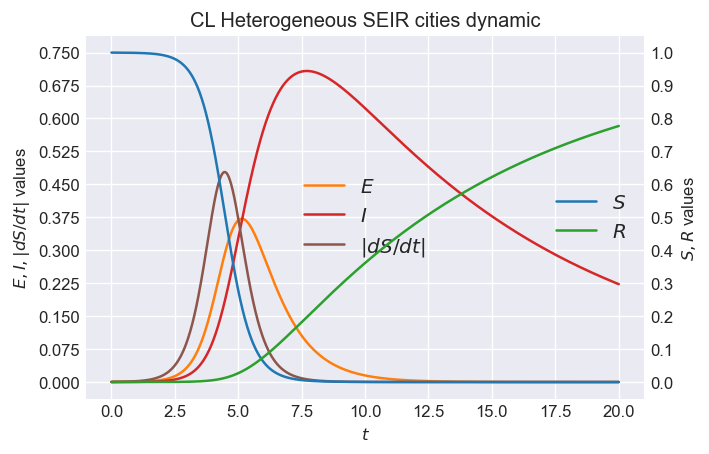

In [15]:
theta=0.1
l=1.0e-6
h=0.05
infected_threshold=i0*4.0
icd=incity_dynamics(r0_0,i0,τ,vs0,vb0,infected_threshold,l,h,theta,theta/2)
S,E,I,R,dS,S_pop,I_pop,R_pop=CL_H_SEIR(icd,I0,w/i0,l,h,5,20,theta)
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, E,color='C1', label=f'$E$')
plt.plot(m_t, I,color='C3', label=f'$I$')
plt.plot(m_t, dS, color='C5', label=f'$|dS/dt|$')
n_tiks=10
tik_left=0.075
ax.set_ylim([-0.05*n_tiks*tik_left,1.05*n_tiks*tik_left])
ax.yaxis.set_major_locator(ticker.MultipleLocator(tik_left))
ax.set_ylabel(f'$E,I,|dS/dt|$ values')
plt.legend(loc='center')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, S, color='C0', label=f'$S$')
plt.plot(m_t, R,color='C2', label=f'$R$')
tik_right=0.1
ax2.set_ylim([-0.05*n_tiks*tik_right,1.05*n_tiks*tik_right])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(tik_right))
ax2.set_ylabel(f'$S,R$ values')
ax2.grid(False)

plt.legend(loc='center right')
plt.title(f'CL Heterogeneous SEIR cities dynamic')
plt.show() 

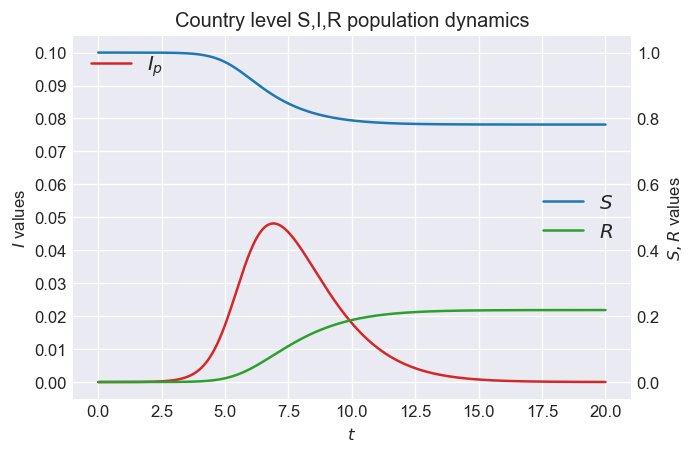

In [16]:
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, I_pop,color='C3', label=f'$I_p$')
n_tiks=10
tik_left=0.01
ax.set_ylim([-0.05*n_tiks*tik_left,1.05*n_tiks*tik_left])
ax.yaxis.set_major_locator(ticker.MultipleLocator(tik_left))
ax.set_ylabel(f'$I$ values')
plt.legend(loc='upper left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, S_pop, color='C0', label=f'$S$')
plt.plot(m_t, R_pop,color='C2', label=f'$R$')
tik_right=0.1
ax2.set_ylim([-0.05*n_tiks*tik_right,1.05*n_tiks*tik_right])
ax2.set_ylabel(f'$S,R$ values')
ax2.grid(False)

plt.legend(loc='center right')
plt.title(f'Country level S,I,R population dynamics')
plt.show() 

Definitely, it is possible to combine country level heterogeneous SEIR model (CL H SEIR) and country level SIR model with step approximation of infectious curve (CL STEP SIR), but it is just technical task.